In [1]:
from DenoiseST import DenoiseST
import os
import torch
import pandas as pd
import numpy as np
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

n_clusters = 7
file_fold = './151673'
adata = sc.read_visium(file_fold, count_file='filtered_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique()

/root/miniconda3/envs/DiffusionST/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
model = DenoiseST(adata,device=device,n_top_genes=4096)
adata = model.train()

Begin to train ST data...


100%|██████████| 500/500 [00:37<00:00, 13.27it/s]

Optimization finished for ST data!


In [4]:
from repair_model import main_repair
df=pd.DataFrame(adata.obsm['emb'])

In [5]:
main_repair(adata,df,device)

/root/miniconda3/envs/DiffusionST/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Processing: 100%|██████████| 3639/3639 [4:16:11<00:00,  4.22s/it]  


[[ 0.12087565  0.02576069  0.32580745 ...  1.57413578  0.05374574
   0.18592943]
 [ 0.14916809  0.0485357   0.84785616 ...  0.42930076  0.09064695
   0.04181869]
 [-0.00433761  0.10986754  0.09789092 ...  0.34350592  0.22000438
   0.21815532]
 ...
 [ 0.13603982  0.02032037  0.10227085 ...  0.04750852  0.12854326
  -0.02608382]
 [ 0.27479482  0.07008605  0.39590028 ...  0.20990837 -0.06909621
   0.02492007]
 [ 0.07951874  0.05430695  0.06294988 ...  0.09903098  0.58416206
  -0.0531359 ]]
0 : [[ 0.12087565  0.02576069  0.32580745 ...  1.57413578  0.05374574
   0.18592943]
 [ 0.14916809  0.0485357   0.84785616 ...  0.42930076  0.09064695
   0.04181869]
 [-0.00433761  0.10986754  0.09789092 ...  0.34350592  0.22000438
   0.21815532]
 ...
 [ 0.13603982  0.02032037  0.10227085 ...  0.04750852  0.12854326
  -0.02608382]
 [ 0.27479482  0.07008605  0.39590028 ...  0.20990837 -0.06909621
   0.02492007]
 [ 0.07951874  0.05430695  0.06294988 ...  0.09903098  0.58416206
  -0.0531359 ]]
[[-0.2248310

In [6]:
csv_file = "example.csv"
data_df = pd.read_csv(csv_file, header=None)
data_df = data_df.values
adata.obsm['emb'] = data_df

In [ ]:
from utils import clustering

radius = 50
tool = 'mclust' # mclust, leiden, and louvain
if tool == 'mclust':
   clustering(adata, n_clusters, radius=radius, method=tool, refinement=True)
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


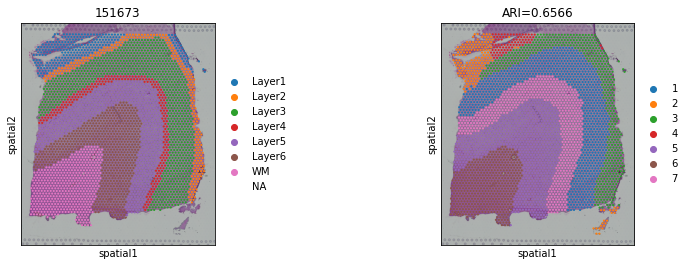

In [ ]:
# add ground_truth
df_meta = pd.read_csv(file_fold + '/metadata.tsv', sep='\t')
df_meta_layer = df_meta['layer_guess']
adata.obs['ground_truth'] = df_meta_layer.values
# filter out NA nodes
adata = adata[~pd.isnull(adata.obs['ground_truth'])]
ARI = metrics.adjusted_rand_score(adata.obs['domain'],adata.obs['ground_truth'])
df_domain=adata.obs['domain']
df_ground_truth=adata.obs['ground_truth']
df_domain.to_csv("TOGAR_151673_no_NA.csv")
plots = sc.pl.spatial(
        adata,
        img_key="hires",
        color=["ground_truth", "domain"],
        title=[f"{151673}", "ARI=%.4f" % ARI],
        show=False
    )